In [1]:
# Para que se carguen los .py automáticamente cada vez que los modifico
# De esta manera no tengo que estar resstarting the kernel
%load_ext autoreload
%autoreload 2

# Basic libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# Pymoo elementwise problem for thread execution
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# My functions
from uav_model import uav_model
from uav_model import param_evolve

from uav_simulator import pid_class
from uav_simulator import uav_info
from uav_simulator import curves
from uav_simulator import simulator
from uav_simulator import simulator_v2

from guidance import serret_frenet_angle
from guidance import LOS_angle
from guidance import uav_SF_angle


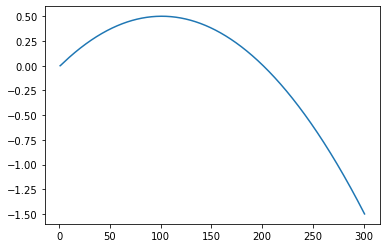

In [2]:
# test simu
psi0 = 0; s = 1;
x0 = [s*np.cos(psi0),s*np.sin(psi0),psi0,0.1]

Ts = 0.1; tmax = 300;
res = sp.integrate.solve_ivp(uav_model, [0,tmax], x0, args=(1,-0.001),
                             dense_output=True)
tt = np.linspace(0,tmax,2000)
sol = res.sol(tt).T;
plt.plot(sol[:,0],sol[:,1])

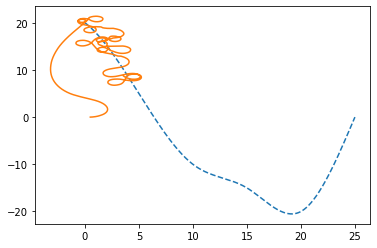

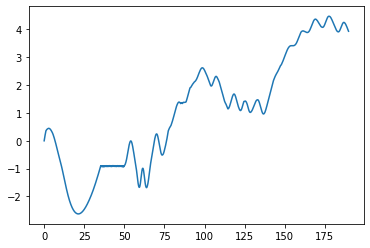

In [3]:
#x0,p0,s,Ts,tmax,tsplines,xsplines,ysplines,kp,ki,kd,ks
psi0 = 0; s = 0.5; p0 = np.array([0]);
x0 = [s*np.cos(psi0),s*np.sin(psi0),psi0,0.0]
Ts = 0.1; tmax = 190;
tsplines = np.array([1,2,3,4,5])*5
xsplines = np.array([1,2,3,4,5])*5
ysplines = np.array([1,-2,-3,-4,0])*5

kp = 1.9; ki = 0; kd = 0.1; ks = 0.01;

# Now simulator is working, lets optimize kp, ki, kd in order to mimize the error (for now)
tt,uav_inf,p = simulator(x0, p0, s, Ts, tmax, tsplines, xsplines, ysplines, 1.17, 1.32, 1.47 ,ks)

t2 = np.linspace(0,tsplines[-1],1000)
ss = sp.interpolate.CubicSpline(tsplines, np.c_[xsplines,ysplines], bc_type="natural")
sx,sy = ss(t2).T
plt.plot(sx,sy,'--')
plt.plot(uav_inf.px,uav_inf.py)
plt.figure()
plt.plot(tt,p)

In [91]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
import scipy as sp
from scipy import integrate

class problema_ew(ElementwiseProblem):
    
    def __init__(self, x0, p0, s, Ts, tmax, tsplines, xsplines, ysplines, **kwargs):
        self.x0 = x0
        self.p0 = p0
        self.s = s
        self.Ts = Ts
        self.tmax = tmax
        self.tsplines = tsplines
        self.xsplines = xsplines
        self.ysplines = ysplines
        self.n_var = 4 # kp,ki,kd,ks
        self.xl = np.array([0.1,0,0, 0.005])
        self.xu = np.array([200,200,200, 1])
        super().__init__(n_var            = self.n_var,  # Variables de decisión
                             n_obj        = 4,           # orientation error, distance error
                             n_ieq_constr = 2,           # 
                             n_eq_constr  = 0,           # 
                             xl           = self.xl,     # Acotar variables de decisión
                             xu           = self.xu,
                             **kwargs)


    def simulator_problema_v2(self,kp,ki,kd,ks):
        x0 = self.x0
        p0 = self.p0
        s = self.s
        Ts = self.Ts
        tmax = self.tmax
        tsplines = self.tsplines
        xsplines = self.xsplines
        ysplines = self.ysplines
        
        niter = int(tmax // Ts)
        
        # Curves
        curve = curves()
    
        # init pid
        pid = pid_class(kp=kp,ki=ki,kd=kd,max_sum=400,dt=Ts)
        
        # For later info
        uav_inf = uav_info(s)
        pp = []; tt = []
        
        for k in range(niter):
        
            # do it better
            if(p0 > tsplines[-1]): 
                break
                
            px = x0[0]; py = x0[1];
            psi = x0[2]; omega = x0[3]
            curve.eval_spline(tsplines, 
                              xsplines,ysplines,
                              p0)
            
            f = curve.f; df = curve.df;
        
            eN = f[0] - px # x
            eT = f[1] - py # y
            psiLOS = LOS_angle(eN,eT)
            psiT   = serret_frenet_angle(df[0],df[1])
            psiSF  = uav_SF_angle(psi,psiT)
        
            """ If we follow LOS, we converge to SF"""
            e = (psiLOS - psi)
            u = pid.compute_pid(e)
            
            if(u >= 2*np.pi):
                u = 2*np.pi
            elif(u <= -2*np.pi):
                u = -2*np.pi;
            
            """ Distance error """
            ed = np.sqrt( eN**2 + eT**2)
            x = np.array([px,py,psi,omega])
            
            xdot_uav = uav_model(k*Ts, x, s, u)
            # As paper
            xdot_frenet = param_evolve(k*Ts, 0, s, psiSF, ks, eT, df)
            #As me
            #xdot_frenet = param_evolve(k*Ts, 0, s, psiSF, ks, eN**2, df)
    
            # integrate by Euler
            x0 = x0 + xdot_uav * Ts;
            p0 = p0 + xdot_frenet * Ts

            # save states and error
            uav_inf.append(px,py,psi,omega,u,e,ed,psiSF)
            pp = np.append(pp,p0)
            tt = np.append(tt,k*Ts)
            #x0 = res.y[:,-1]
            #p0 = resp.y[:,-1]
        
        return tt, uav_inf, pp   
        
    # Maybe using simulator() is bringin problems when paralelizing.
    # Maybe it is better to do the simulator function INSIDE the problem
    # YEAP I THINK SO. TEST IT, RIGHT NOW PARALELIZATION IS NOT WORKING AND IT IS ESSENTIAL..........


    
    def _evaluate(self,x,out,*args,**kwargs):
        # objective function (minimize accumulated orientation error w.r.t to LOS)
        f1 = 0
        # objective function 2 (minimize distance error to path)
        f2 = 0
        # Objective function 3 (minimize control action)
        f3 = 0

        # Restriction 1: max_error_distance <= nmetros
        g1 = 0
        # Restriction 2: Finish mission before max time
        
        kp = x[0]; ki = x[1]; kd = x[2]; ks = x[3] 
        tt,uav_inf,p = self.simulator_problema_v2(kp, ki, kd, ks)
        f1 = sp.integrate.trapz(uav_inf.e**2, tt)
        f2 = sp.integrate.trapz(uav_inf.ed,tt)
        f3 = sp.integrate.trapz(uav_inf.u**2, tt)
        f4 = sp.integrate.trapz(uav_inf.eSF**2,tt)

        # max 1 metros ESTO PUEDE CON ELLO LE CUESTA LA UNIÓN DE AMBAS
        g1 = np.max(uav_inf.ed) - 2.1
        # Si acaba antes de el máximo, significa que
        # el parámetro NO se ha quedado enganchado
        g2 = tt[-1] - (self.tmax-2)
        #g2 = -1;
        
        out["F"] = np.array([f1,f2,f3,f4])
        out["G"] = np.array([g1,g2])
        


In [92]:
psi0 = 0; s = 1.2; p0 = np.array([0]);
Ts = 0.1; tmax = 230;
tsplines = np.array([0,1,2,3,4,5])*1
xsplines = np.array([1,2,3,4,3, 0])*15
ysplines = np.array([1,-2,-3,-1,0, 1])*15


curvi = curves()
curvi.eval_spline(tsplines, 
                  xsplines,ysplines,
                  p0)
psi0 = np.arctan2(curvi.df[1],curvi.df[0])
x0 = [xsplines[0],ysplines[0],psi0,0.0]

algorithm = NSGA2(pop_size=50)
#def __init__(self, x0, p0, s, Ts, tmax, tsplines, xsplines, ysplines, ks, **kwargs):
prob = problema_ew(
                  x0=x0, p0=p0, s=s, Ts=Ts,
                  tmax=tmax, 
                  tsplines=tsplines,xsplines=xsplines,ysplines=ysplines) 

res = minimize(prob, algorithm, ('n_gen',100), seed=np.random.randint(1000), verbose=True)
print("Test: ", res.exec_time)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      1 |  6.1310734109 |  7.144606E+01 |             - |             -
     2 |      100 |      1 |  2.7992031094 |  5.029789E+01 |             - |             -
     3 |      150 |      1 |  0.7236969972 |  2.043496E+01 |             - |             -
     4 |      200 |      1 |  0.7236969972 |  5.4801682704 |             - |             -
     5 |      250 |      1 |  0.7236969972 |  3.5123172266 |             - |             -
     6 |      300 |      1 |  0.7133507187 |  2.1919416816 |             - |             -
     7 |      350 |      1 |  0.7133507187 |  1.3566840832 |             - |             -
     8 |      400 |      1 |  0.4416192419 |  1.0574128213 |             - |             -
     9 |      450 |      1 |  0.4416192419 |  0.9640184455 |             - |             -
    10 |      500 |      1 |  0.4416192419 |  0.9247930833 |             - |             -

In [136]:
psi0 = 0; s = 1.2; p0 = np.array([0]);
Ts = 0.1; tmax = 230;
tsplines = np.array([0,1,2,3,4,5])*1
xsplines = np.array([1,2,3,4,3, 0])*15
ysplines = np.array([1,-2,-3,-1,0, 1])*15


curvi = curves()
curvi.eval_spline(tsplines, 
                  xsplines,ysplines,
                  p0)
psi0 = np.arctan2(curvi.df[1],curvi.df[0])
x0 = [xsplines[0],ysplines[0],psi0,0.0]


# minimize orientation error from pareto front
l = np.argmin(res.F[:,1])

kp = res.X[l,0]; ki = res.X[l,1]; kd = res.X[l,2]; ks = res.X[l,3]

#### LAST OOPTIMIZATION ##########
#kp = 100.25; ki = 100.24; kd = 100.530; ks = 0.0080;

#kp = 100; ki =0; kd = 0; ks = 0.08
import time

ei = time.time()
# Now simulator is working, lets optimize kp, ki, kd in order to mimize the error (for now)
tt,uav_inf,p = simulator_v2(x0, p0, s, Ts, tmax, tsplines, xsplines, ysplines, kp, ki, kd ,ks)
ef = time.time()
print(ef-ei)
print(kp,ki,kd,ks,tt[-1])

%matplotlib
plt.figure(figsize=(30,14))
plt.subplot(221)
t2 = np.linspace(0,tsplines[-1],1000)
ss = sp.interpolate.CubicSpline(tsplines, np.c_[xsplines,ysplines], bc_type="natural")
sx,sy = ss(t2).T
plt.plot(sx,sy,'--',label='desired')
plt.plot(uav_inf.px,uav_inf.py,label='actual')
plt.axis('equal')
plt.xlabel("$p_x(t)$ (m)",fontsize=25); plt.ylabel("$p_y(t)$ (m)",fontsize=25)
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.title("Desired and actual trajectory",fontsize=25)
plt.legend(fontsize=25)

plt.subplot(222)
plt.plot(tt,uav_inf.e)
plt.xlabel("$t$ (s)",fontsize=25); plt.ylabel("$\psi(t) - \psi_{LOS}(t)$ (rad)",fontsize=25)
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.title("Error between $\psi$ and $\psi_{LOS}$",fontsize=25)

plt.subplot(223)
plt.plot(tt,uav_inf.ed)
plt.xlabel("$t$ (s)",fontsize=25); plt.ylabel("$d(t) = ||p(t)-f(s(t))||_2$ (m)",fontsize=25)
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.title("Distance to path $f(s)$",fontsize=25)

plt.subplot(224)
plt.plot(tt,uav_inf.u)
plt.xlabel("$t$ (s)",fontsize=25); plt.ylabel("$u(t)$ (m)",fontsize=25)
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.title("Control signal $u(t)$",fontsize=25)

plt.tight_layout()

plt.figure(figsize=(30,14))
plt.subplot(221)
plt.plot(tt,uav_inf.px,label="$p_x$")
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylabel("$p_x(t)$ (m)",fontsize=25); plt.xlabel("t (s)",fontsize=25)
plt.title("Actual $p_x$ position",fontsize=25)

plt.subplot(222)
plt.plot(tt,uav_inf.py,label="$p_y$")
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylabel("$p_y(t)$ (m)",fontsize=25); plt.xlabel("t (s)",fontsize=25)
plt.title("Actual $p_y$ position",fontsize=25)

plt.subplot(2,2,3)
plt.plot(tt,uav_inf.psi,label="$\psi$")
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylabel("$\psi(t)$ (rad)",fontsize=25); plt.xlabel("t (s)",fontsize=25)
plt.title("Heading angle $\psi$",fontsize=25)

plt.subplot(224)
plt.plot(tt,p,label="Parameter $s$")
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylabel("$s(t)$",fontsize=25); plt.xlabel("t (s)",fontsize=25)
plt.title("Parameter of the path $s(t)$",fontsize=25)

plt.tight_layout()

0.22016644477844238
88.6316180275092 2.8181741452102766 49.06143450742865 0.005666901087202207 148.8
Using matplotlib backend: TkAgg


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
